In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import warnings
import collections
warnings.filterwarnings('ignore')

## Data aggregation and manipulation: 

### Loading gamer data

In [2]:
data = pd.read_csv('steamUsers.csv', sep=',')

### cleaning gamer data

In [3]:
#Removed the useless 0 column 
data = data.drop('0', 1)
nRawRows = data.shape[0]

In [4]:
#Removed duplicates
data.drop_duplicates(subset=None, keep="first", inplace=True)
print(nRawRows, "rows before removing duplicates")
nRows = data.shape[0]
print(nRows, "rows after removing duplicates")

200000 rows before removing duplicates
199293 rows after removing duplicates


### Purchased without playing

In [5]:
nonPlayedGames = pd.DataFrame(data)
nonPlayedGames.drop_duplicates(subset=['gamerId','gameName'], keep=False, inplace=True)
nNPlayed = nonPlayedGames.shape[0]
print(nNPlayed, "games were purchased but never played")
d = {1.0:0.5}
nonPlayedGames = nonPlayedGames.replace(d)
nonPlayedGames = nonPlayedGames.drop('Action', 1)
nonPlayedGames.head()

58327 games were purchased but never played


,gamerId,gameName,playHours
52,151603712,Alan Wake,0.5
53,151603712,BioShock 2,0.5
54,151603712,Fallen Earth,0.5
55,151603712,Fallout New Vegas Courier's Stash,0.5
56,151603712,Fallout New Vegas Dead Money,0.5


### Purchased and played

In [6]:
playCheck = data.Action.str.contains('play') 
playedGames = data[playCheck] 
nplayed = playedGames.shape[0]
print(nplayed, "games were purchased and played")
playedGames = playedGames.drop('Action', 1)
playedGames.head()

70489 games were purchased and played


,gamerId,gameName,playHours
1,151603712,The Elder Scrolls V Skyrim,273.0
3,151603712,Fallout 4,87.0
5,151603712,Spore,14.9
7,151603712,Fallout New Vegas,12.1
9,151603712,Left 4 Dead 2,8.9


### combining played and non played dataset

In [7]:
frames = [playedGames, nonPlayedGames]

ppgames = pd.concat(frames,ignore_index=True)
ppgames.sort_values(by=['gamerId', 'gameName'])
ppgames.head()


,gamerId,gameName,playHours
0,151603712,The Elder Scrolls V Skyrim,273.0
1,151603712,Fallout 4,87.0
2,151603712,Spore,14.9
3,151603712,Fallout New Vegas,12.1
4,151603712,Left 4 Dead 2,8.9


In [8]:
ppgames.shape


(128816, 3)

### Load games data

In [9]:
gamesData = pd.read_csv('steamGames.csv', sep=',')
gamesData.rename(columns={'name': 'gameName'}, inplace=True)
gamesData.head(6)

,appid,gameName,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99
5,60,Ricochet,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Valve Anti-Ch...,Action,Action;FPS;Multiplayer,0,2758,684,175,10,5000000-10000000,3.99


### Merging gamer data with games data

In [10]:
catgames = ppgames.merge(gamesData[['gameName','appid','categories']], how='left', on='gameName')
catgames.dropna(inplace=True)
catgames.head()


,gamerId,gameName,playHours,appid,categories
1,151603712,Fallout 4,87.0,377160.0,Single-player;Steam Achievements;Full controll...
4,151603712,Left 4 Dead 2,8.9,550.0,Single-player;Multi-player;Co-op;Steam Achieve...
5,151603712,HuniePop,8.5,339800.0,Single-player;Steam Achievements;Steam Trading...
6,151603712,Path of Exile,8.1,238960.0,Single-player;Multi-player;Online Multi-Player...
7,151603712,Poly Bridge,7.5,367450.0,Single-player;Steam Achievements;Steam Trading...


In [11]:
catgames.appid = catgames.appid.apply(int)
catgames

,gamerId,gameName,playHours,appid,categories
1,151603712,Fallout 4,87.0,377160,Single-player;Steam Achievements;Full controll...
4,151603712,Left 4 Dead 2,8.9,550,Single-player;Multi-player;Co-op;Steam Achieve...
5,151603712,HuniePop,8.5,339800,Single-player;Steam Achievements;Steam Trading...
6,151603712,Path of Exile,8.1,238960,Single-player;Multi-player;Online Multi-Player...
7,151603712,Poly Bridge,7.5,367450,Single-player;Steam Achievements;Steam Trading...
...,...,...,...,...,...
128848,88705345,Neverwinter,0.5,109600,Multi-player;MMO;Co-op;Steam Trading Cards;In-...
128849,88705345,RIFT,0.5,39120,Multi-player;Online Multi-Player;MMO;Co-op;Onl...
128850,188089669,Unturned,0.5,304930,Single-player;Online Multi-Player;Online Co-op...
128851,68081395,iBomber Defense Pacific,0.5,206690,Single-player


### Converting categories in one hot format

In [12]:
#catonehot = catgames.drop(columns=['appid','gameName','playHours'])
catonehot = catgames
def splitCat(x):
    if x['categories'] is np.nan:
        return x
    else:
        genres = list(map(lambda y: y.strip(), x['categories'].split(';')))
        for g in genres:
            x[g] = 1
        return x

catonehot = catonehot.apply(splitCat, axis=1)
catonehot = catonehot.fillna(value=0)

catonehot


,Captions available,Co-op,Commentary available,Cross-Platform Multiplayer,Full controller support,In-App Purchases,Includes Source SDK,Includes level editor,Local Co-op,Local Multi-Player,...,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,VR Support,Valve Anti-Cheat enabled,appid,categories,gameName,gamerId,playHours
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,377160,Single-player;Steam Achievements;Full controll...,Fallout 4,151603712,87.0
4,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,550,Single-player;Multi-player;Co-op;Steam Achieve...,Left 4 Dead 2,151603712,8.9
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,339800,Single-player;Steam Achievements;Steam Trading...,HuniePop,151603712,8.5
6,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,238960,Single-player;Multi-player;Online Multi-Player...,Path of Exile,151603712,8.1
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,367450,Single-player;Steam Achievements;Steam Trading...,Poly Bridge,151603712,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128848,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,109600,Multi-player;MMO;Co-op;Steam Trading Cards;In-...,Neverwinter,88705345,0.5
128849,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,39120,Multi-player;Online Multi-Player;MMO;Co-op;Onl...,RIFT,88705345,0.5
128850,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,304930,Single-player;Online Multi-Player;Online Co-op...,Unturned,188089669,0.5
128851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206690,Single-player,iBomber Defense Pacific,68081395,0.5


In [13]:
ncats = catonehot.shape[1]-5
print("We found", ncats, "categories")

We found 27 categories


### Calculating categories weights for each gamer

In [136]:
finalgameset = catonehot 
finalgameset = finalgameset.drop(['gameName','appid', 'categories'], axis=1)

attr = finalgameset.columns.tolist()
attr.remove('playHours')
attr.remove('gamerId')
finalgameset[attr] = finalgameset[attr].mul(finalgameset['playHours'], axis=0)

finalgameset = (finalgameset
         .groupby(by='gamerId')
         .mean())

finalgameset = finalgameset.drop(['playHours'], axis=1)
finalgameset



,Captions available,Co-op,Commentary available,Cross-Platform Multiplayer,Full controller support,In-App Purchases,Includes Source SDK,Includes level editor,Local Co-op,Local Multi-Player,...,Stats,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,VR Support,Valve Anti-Cheat enabled
gamerId,,,,,,,,,,,,,,,,,,,,,
5250,1.691667,1.558333,1.241667,0.066667,1.133333,0.083333,0.083333,1.650000,0.00,0.125000,...,1.608333,1.691667,1.625000,0.000000,1.258333,0.0,1.216667,0.016667,0.00,0.333333
76767,1.392308,1.284615,1.153846,0.000000,1.330769,0.000000,0.000000,1.253846,0.00,28.153846,...,1.215385,3.238462,1.484615,0.038462,1.192308,0.0,1.153846,0.000000,0.00,28.323077
86540,0.724000,1.600000,0.684000,0.144000,0.752000,0.000000,0.684000,0.068000,0.04,0.080000,...,0.676000,1.000000,0.896000,0.000000,0.896000,0.0,0.820000,0.000000,0.00,0.776000
103360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.250000,...,0.000000,0.000000,0.083333,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.500000
144736,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.183333,...,0.000000,0.000000,0.083333,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.433333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309404240,0.550000,0.000000,0.550000,0.550000,0.000000,3.800000,0.000000,3.875000,0.00,0.000000,...,3.800000,4.050000,3.425000,0.000000,4.050000,0.0,3.800000,0.000000,3.25,3.800000
309434439,0.000000,0.800000,0.000000,0.000000,0.000000,0.800000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.800000,0.0,0.800000,0.800000,0.00,0.800000
309812026,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.500000,0.000000,0.000000,0.500000,0.0,0.000000,0.000000,0.00,0.000000


In [138]:
#if a categorie is empty we remove it
nullTags = []
for c in finalgameset.columns:
    if (finalgameset[c] == 0).all():
        nullTags.append(c)

if nullTags != []:
    finalgameset = finalgameset.drop(columns=nullTags)

newNcat = finalgameset.shape[1]

if ncats > newNcat:
    print(ncats - newNcat, "categories were removed")
else:
    print("no categorie has been removed")


no categorie has been removed


### normalization

In [139]:
from sklearn.preprocessing import StandardScaler

SC = StandardScaler()
SC.fit(finalgameset)
xnorm=SC.transform(finalgameset)

### PCA

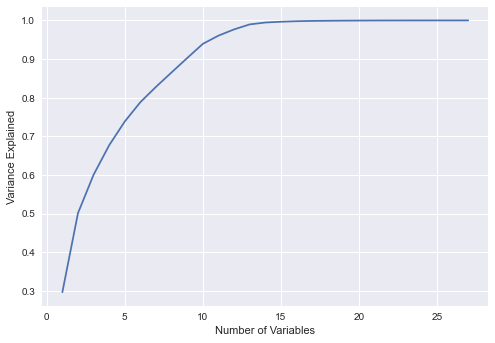

In [140]:
pca = PCA()
pca.fit(xnorm)

acc_var = np.cumsum(pca.explained_variance_ratio_) 

plt.style.use('seaborn')
plt.plot(range(1, len(acc_var)+1), acc_var)
plt.xlabel('Number of Variables')
_ = plt.ylabel('Variance Explained')

In [176]:
#between 5 and 10 we pick 8
number_of_components = 6
pca.set_params(n_components=number_of_components)
pca.fit(xnorm)
gamers_pca = pca.transform(xnorm)
gamers_pos_pca = pd.DataFrame(gamers_pca)
gamers_pos_pca['gamerId'] = finalgameset.index
gamers_pos_pca = gamers_pos_pca.set_index('gamerId')
gamers_pos_pca.head()

,0,1,2,3,4,5
gamerId,,,,,,
5250,-0.611256,0.209126,-0.229617,-0.078255,-0.062365,-0.046803
76767,-0.527509,0.141570,-0.072563,0.503040,-0.322938,-0.073666
86540,-0.624910,0.194279,-0.223370,-0.081188,-0.063144,-0.055441
103360,-0.653230,0.175020,-0.279509,-0.052728,-0.043588,-0.041601
144736,-0.653425,0.175190,-0.279823,-0.054125,-0.042966,-0.041522


### quadratic error

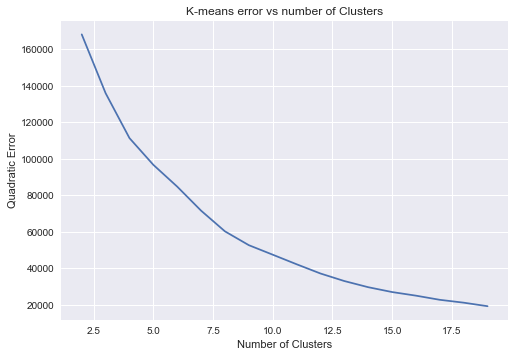

In [177]:
inertia = []
scores = []
for n_clusters in range(2, 20):
    kmeans = KMeans(n_clusters=n_clusters, n_jobs=-1)
    kmeans.fit(gamers_pos_pca)
    inertia.append(kmeans.inertia_)
plt.plot(range(2, 20), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Quadratic Error')
_ = plt.title('K-means error vs number of Clusters')

## Kmeans prediction and 3D plot

In [200]:
#project the users feature vector in 3 dimensions
gamers_with_label = pd.DataFrame(PCA(n_components=3).fit_transform(finalgameset))
gamers_with_label['gamerId'] = finalgameset.index
gamers_with_label = gamers_with_label.set_index('gamerId')

#find each user's cluster
kmeans = KMeans(n_clusters=7, n_jobs=-1)
gamers_with_label['label'] = kmeans.fit_predict(gamers_pos_pca)
gamers_with_label.shape

(10121, 4)

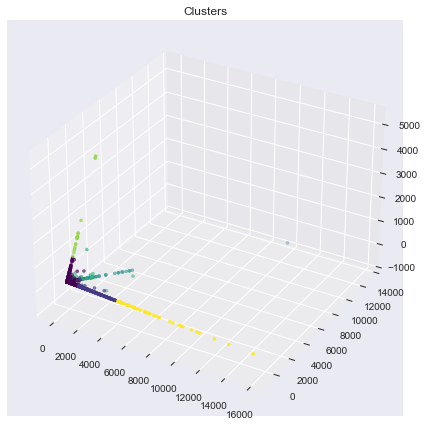

In [201]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(gamers_with_label[0], gamers_with_label[1], gamers_with_label[2], c=gamers_with_label['label'].to_numpy(), cmap='viridis', s=10)
_ = plt.title('Clusters')

In [202]:
clustersMembers = {}
for idx, val in (pd.get_dummies(gamers_with_label['label'])).sum().iteritems():
    clustersMembers[idx] = val

for p in clustersMembers:
    print("Cluster", p,"has",clustersMembers[p],"gamers")

Cluster 0 has 9680 gamers
Cluster 1 has 294 gamers
Cluster 2 has 1 gamers
Cluster 3 has 31 gamers
Cluster 4 has 46 gamers
Cluster 5 has 17 gamers
Cluster 6 has 52 gamers


In [203]:
testingd = finalgameset.join(gamers_with_label[['label']], on='gamerId')
testingd

,Captions available,Co-op,Commentary available,Cross-Platform Multiplayer,Full controller support,In-App Purchases,Includes Source SDK,Includes level editor,Local Co-op,Local Multi-Player,...,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,VR Support,Valve Anti-Cheat enabled,label
gamerId,,,,,,,,,,,,,,,,,,,,,
5250,1.691667,1.558333,1.241667,0.066667,1.133333,0.083333,0.083333,1.650000,0.00,0.125000,...,1.691667,1.625000,0.000000,1.258333,0.0,1.216667,0.016667,0.00,0.333333,0
76767,1.392308,1.284615,1.153846,0.000000,1.330769,0.000000,0.000000,1.253846,0.00,28.153846,...,3.238462,1.484615,0.038462,1.192308,0.0,1.153846,0.000000,0.00,28.323077,0
86540,0.724000,1.600000,0.684000,0.144000,0.752000,0.000000,0.684000,0.068000,0.04,0.080000,...,1.000000,0.896000,0.000000,0.896000,0.0,0.820000,0.000000,0.00,0.776000,0
103360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.250000,...,0.000000,0.083333,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.500000,0
144736,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.183333,...,0.000000,0.083333,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.433333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309404240,0.550000,0.000000,0.550000,0.550000,0.000000,3.800000,0.000000,3.875000,0.00,0.000000,...,4.050000,3.425000,0.000000,4.050000,0.0,3.800000,0.000000,3.25,3.800000,0
309434439,0.000000,0.800000,0.000000,0.000000,0.000000,0.800000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.800000,0.0,0.800000,0.800000,0.00,0.800000,0
309812026,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.00,0.000000,...,0.500000,0.000000,0.000000,0.500000,0.0,0.000000,0.000000,0.00,0.000000,0


In [204]:
categories = list(catonehot.columns)
categories

['Captions available',
 'Co-op',
 'Commentary available',
 'Cross-Platform Multiplayer',
 'Full controller support',
 'In-App Purchases',
 'Includes Source SDK',
 'Includes level editor',
 'Local Co-op',
 'Local Multi-Player',
 'MMO',
 'Multi-player',
 'Online Co-op',
 'Online Multi-Player',
 'Partial Controller Support',
 'Shared/Split Screen',
 'Single-player',
 'Stats',
 'Steam Achievements',
 'Steam Cloud',
 'Steam Leaderboards',
 'Steam Trading Cards',
 'Steam Turn Notifications',
 'Steam Workshop',
 'SteamVR Collectibles',
 'VR Support',
 'Valve Anti-Cheat enabled',
 'appid',
 'categories',
 'gameName',
 'gamerId',
 'playHours']

In [268]:
clutersMembers = (testingd
          .groupby(['label']))


for key, item in clutersMembers:
    recommandedGames = pd.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)
    print('Most important categories for gamers in cluster', key, 'are:\n ')
    
    
    values = clutersMembers.get_group(key).drop(labels=['label'],axis=1).mean(axis=0)
    sorted_values = values.sort_values(ascending=False)
    print(sorted_values.index[0],',', sorted_values.index[1],'and', sorted_values.index[2],'\n \n')
    
    sorted_values.index[1], sorted_values.index[2]
    
    catCheck = gamesData.categories.str.contains(sorted_values.index[0]) & gamesData.categories.str.contains(sorted_values.index[1]) & gamesData.categories.str.contains(sorted_values.index[2]) & gamesData.categories.str.contains(sorted_values.index[3])
    
    
    recommandedGames = gamesData[catCheck] 
    globals()['recommandedGames%s' % key] = gamesData[catCheck] 
    
    
    
    
    


    

    


    
    
    
    
    
    
    

Most important categories for gamers in cluster 0 are:
 
Multi-player , Steam Trading Cards and Valve Anti-Cheat enabled 
 

Most important categories for gamers in cluster 1 are:
 
Multi-player , In-App Purchases and Steam Trading Cards 
 

Most important categories for gamers in cluster 2 are:
 
Captions available , Includes level editor and Steam Workshop 
 

Most important categories for gamers in cluster 3 are:
 
Multi-player , Valve Anti-Cheat enabled and Steam Workshop 
 

Most important categories for gamers in cluster 4 are:
 
Multi-player , Single-player and Steam Achievements 
 

Most important categories for gamers in cluster 5 are:
 
Valve Anti-Cheat enabled , Multi-player and Online Multi-Player 
 

Most important categories for gamers in cluster 6 are:
 
Multi-player , Steam Trading Cards and Co-op 
 



In [269]:
for c in range(8):
    print("we have", globals()['recommandedGames%s' % c].shape[0], "games to recommand to profil", c, "gamers")



we have 23 games to recommand to profil 0 gamers
we have 69 games to recommand to profil 1 gamers
we have 23 games to recommand to profil 2 gamers
we have 28 games to recommand to profil 3 gamers
we have 944 games to recommand to profil 4 gamers
we have 7 games to recommand to profil 5 gamers
we have 18 games to recommand to profil 6 gamers
we have 27 games to recommand to profil 7 gamers


In [222]:
def getGamerProfil(id):
    if id in gamers_with_label.index:
        return int(gamers_with_label.iloc[id].loc['label'])
    else: 
        
        return 'User doesn\'t exist. Are you sure you entered the right id ?'


#getGamerProfil(5250)
getGamerProfil(1)
    

"User doesn't exist. Are you sure you entered the right id ?"

In [271]:
def recommandOnProfil(profilId):
    recommandedGamesNames = globals()['recommandedGames%s' % profilId].gameName.tolist()
    return recommandedGamesNames

recommandOnProfil(1)
    

['Dota 2',
 'Two Worlds II HD',
 'RIFT',
 'Spiral Knights',
 'Neverwinter',
 'AirMech Strike',
 'Closers',
 'PAYDAY 2',
 'Warframe',
 'Killing Floor 2',
 'Path of Exile',
 'Rust',
 'Counter-Strike Nexon: Zombies',
 'Creativerse',
 'S.K.I.L.L. - Special Force 2 (Shooter)',
 'Warface',
 'Robocraft',
 'Call to Arms',
 'Age of Conquest IV',
 'Primal Carnage: Extinction',
 'Supraball',
 'Heavy Metal Machines',
 'Combat Monsters',
 'Demise of Nations',
 'Immortal Empire',
 "Tom Clancy's Rainbow Six® Siege",
 'Tom Clancy’s The Division™',
 'RPG MO',
 'Warhammer 40,000: Eternal Crusade',
 'Crossout',
 'Shot Online',
 'Faeria',
 'Business Tour - Board Game with Online Multiplayer',
 'Guardians of Orion (Phase 1)',
 'Unfortunate Spacemen',
 'BATTLECREW™ Space Pirates',
 'Emporea: Realms of War and Magic',
 'Mech Anarchy',
 'Spacelords',
 'Line of Sight',
 'Armored Warfare',
 'Atomic Space Command',
 'Madness Cubed',
 "Tom Clancy's Ghost Recon® Wildlands",
 'Killbot',
 'Call of Duty®: WWII',
 'Ba

In [273]:
def checkOwnerGames(Gamerid):
    OwnedGames = []
    recommandedGames = []
    gamerProfil = getGamerProfil(Gamerid)
    recommandedGames = recommandOnProfil(gamerProfil)
    OwnedGames = ppgames.loc[ppgames['gamerId'] == Gamerid, 'gameName'].values.tolist()
    gameIntersection = list(set(recommandedGames) & set(OwnedGames))
    return gameIntersection

    
checkOwnerGames(5250)  
    

['Team Fortress 2', 'Dota 2']

In [274]:
def recommandToGamer(Gamerid):
    OwnedGames = []
    recommandedGames = []
    gamerProfil = getGamerProfil(Gamerid)
    if gamerProfil in range(8):
        recommandedGames = recommandOnProfil(gamerProfil)
        OwnedGames = ppgames.loc[ppgames['gamerId'] == Gamerid, 'gameName'].values.tolist()
        gameIntersection = list(set(recommandedGames) & set(OwnedGames))
        if gameIntersection != []:
            print(' You already own: \n')
            for g in gameIntersection:
                print(g,'\n')
                recommandedGames.remove(g)
        print("\n \n", "We recommand: \n ")
        for g in recommandedGames:
            print(g,'\n')
    else:
        print(gamerProfil)
        
        
recommandToGamer(5250)
    
    

 You already own: 

Team Fortress 2 

Dota 2 


 
 We recommand: 
 
Left 4 Dead 2 

Counter-Strike: Global Offensive 

Killing Floor 

Garry's Mod 

Natural Selection 2 

Nuclear Dawn 

Red Orchestra 2: Heroes of Stalingrad with Rising Storm 

ORION: Prelude 

Awesomenauts - the 2D moba 

Tower Wars 

Chivalry: Medieval Warfare 

Insurgency 

Killing Floor 2 

Dying Light 

Rust 

Depth 

Grey Goo 

Block N Load 

DiRT Rally 

Call of Duty®: Black Ops III 

Squad 

